# Import Modules

In [32]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Connect to Local Database

In [33]:

# Create connection to local duckdb database
con = duckdb.connect('../db/duck.db')
%sql con --alias duckdb

# Exploratory Analysis

### NaN, Null & Inf Values

Null values

In [34]:
%%sql
select * from features_normalized where value is null

Running query in 'duckdb'

date,symbol,id,value


Inf values

In [36]:
%%sql
with count_inf as (
    select id, count(*) as count_inf_rows from features_normalized where isinf(value) = true group by id
),
count_all as (
    select id, count(*) as count_all_rows from features_normalized group by id
)
select *, round(count_inf_rows/count_all_rows, 4) as percentage_inf from count_inf join count_all using(id) order by count_inf desc

Running query in 'duckdb'

id,count_inf_rows,count_all_rows,percentage_inf


NaN values

In [37]:
%%sql
with count_nan as (
    select id, count(*) as count_nan_rows from features_normalized where isnan(value) = true group by id
),
count_all as (
    select id, count(*) as count_all_rows from features_normalized group by id
)
select *, round(count_nan_rows/count_all_rows, 4) as percentage_nan from count_nan join count_all using(id) order by count_nan desc

Running query in 'duckdb'

id,count_nan_rows,count_all_rows,percentage_nan


### Distribution of Data

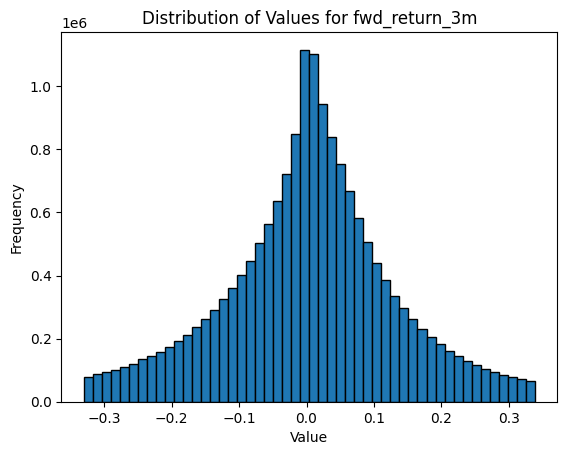

In [21]:
feature = 'fwd_return_3m'
# table = 'features_raw'
table = 'features_cleaned'
# table = 'features_winsorized_id'
# table = 'features_normalized'


# Query the data
query = f"""
SELECT value
FROM {table}
WHERE id = '{feature}' 
--AND date = '2021-01-04'
--and isinf(value) != true;
"""
df = con.execute(query).fetchdf()

# Display the first few rows
df

# Remove outliers
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
df_filtered = df[(df['value'] >= Q1 - 1.5 * IQR) & (df['value'] <= Q3 + 1.5 * IQR)]

# Plot a histogram
plt.hist(df_filtered['value'], bins=50, edgecolor='black')
# plt.hist(df['value'], bins=50, alpha=0.7, edgecolor='black')
plt.title(f'Distribution of Values for {feature}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

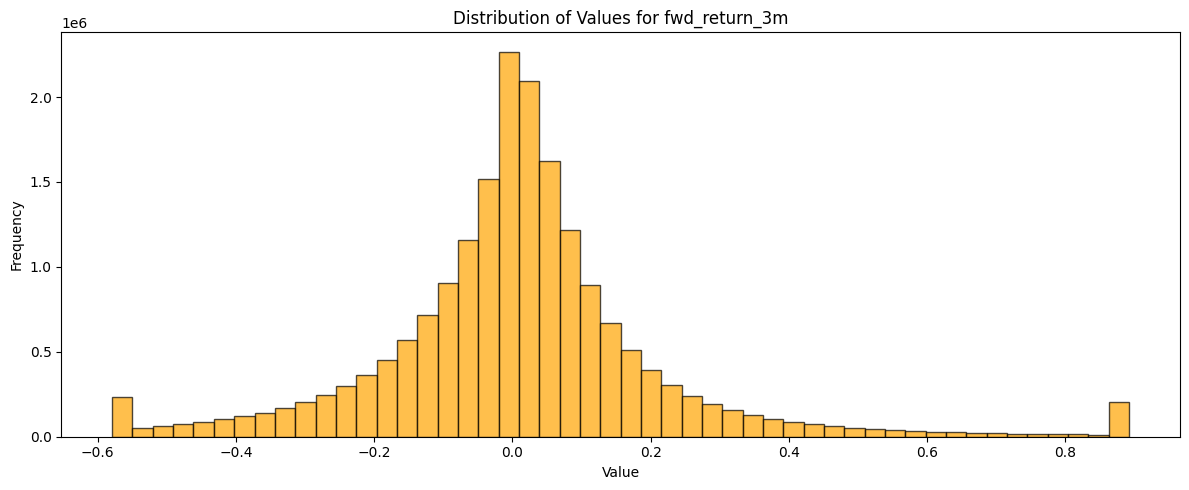

In [30]:
import matplotlib.pyplot as plt
import scipy.stats.mstats as mstats

feature = 'fwd_return_3m'
# table = 'features_raw'
# table = 'features_cleaned'
table = 'features_winsorized_id'
# table = 'features_normalized'


# Query the data
query = f"""
SELECT value
FROM {table}
WHERE id = '{feature}' 
"""
df = con.execute(query).fetchdf()


# Winsorize the data (1% lower & upper percentiles)
df['winsorized_value'] = df['value']
# df['winsorized_value'] = mstats.winsorize(df['value'], limits=[0.01, 0.01])

# Plot the original vs. winsorized distribution
plt.figure(figsize=(12, 5))

# Winsorized Data Histogram
# plt.subplot(1, 2, 2)
plt.hist(df['winsorized_value'], bins=50, edgecolor='black', alpha=0.7, label="Winsorized", color='orange')
plt.title(f'Distribution of Values for {feature}')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


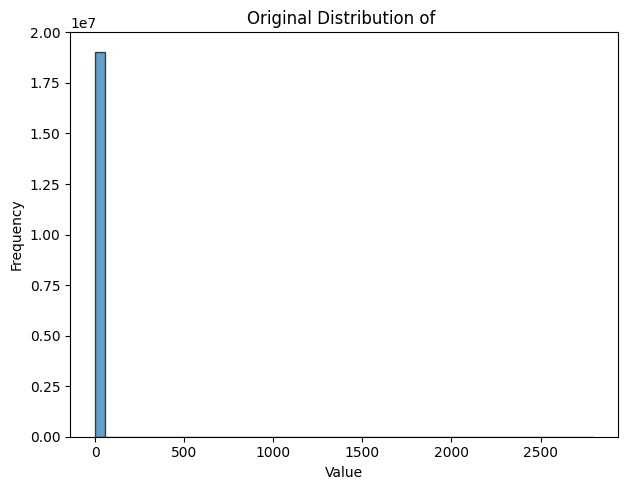

In [22]:
feature = 'fwd_return_3m'
# table = 'features_raw'
table = 'features_cleaned'
# table = 'features_winsorized_id'
# table = 'features_normalized'


# Query the data
query = f"""
SELECT value
FROM {table}
WHERE id = '{feature}' 
--AND date = '2021-01-04'
--and isinf(value) != true;
"""
df = con.execute(query).fetchdf()

# Plot the original vs. winsorized distribution
plt.figure(figsize=(12, 5))

# Original Data Histogram
plt.subplot(1, 2, 1)
plt.hist(df['value'], bins=50, edgecolor='black', alpha=0.7, label="Original")
plt.title('Original Distribution of ')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Close Database Connection

In [38]:
con.close()